# Thiết lập môi trường tổng

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.pardir))

# Thêm đường dẫn gốc vào sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Kiểm tra xem đã nhận chưa
print(f"Project Root: {project_root}")

Project Root: d:\University\HK7\IT_Project\Project\Source


# Khai báo các thư viện / module cần thiết

In [2]:
import pandas as pd

from utils.config import *
from utils.supporter import *

from data.datasets import *
from data.loader import get_data_loader

from engine.trainer import Trainer
from engine.evaluator import *

# Thiết lập cấu hình

## Cấu hình cho các mô hình

In [19]:
# Baseline
spatial_cfg = TrainingConfig('spatial', 'efficientnet')

freq_cfg = TrainingConfig('frequency', 'frequency')
freq_cfg.FREEZE_EPOCHS = 0

# Hybrid approach
# Asymmetric - bất đối xứng
hybrid_asym_cfg = TrainingConfig('hybrid', 'efficientnet_fft_asym')
print("======Asymmetric Fusion") 
print(f"Frequency dim: {hybrid_asym_cfg.MODEL_CONFIG['freq_dim']}")
print(f"Spatial dim: {hybrid_asym_cfg.MODEL_CONFIG['spatial_dim']}")

# Aymmetric - đối xứng
hybrid_sym_cfg = TrainingConfig('hybrid', 'efficientnet_fft_sym') 
hybrid_sym_cfg.MODEL_CONFIG['freq_dim'] = 512
print("\n=====Symmetric Fusion") 
print(f"Frequency dim: {hybrid_sym_cfg.MODEL_CONFIG['freq_dim']}")
print(f"Spatial dim: {hybrid_sym_cfg.MODEL_CONFIG['spatial_dim']}")

======Asymmetric Fusion
Frequency dim: 256
Spatial dim: 512

=====Symmetric Fusion
Frequency dim: 512
Spatial dim: 512


## Thiết lập seed

In [4]:
set_seed(spatial_cfg.RANDOM_SEED, deterministic=False)

[INFO] Random seed set to 42 | deterministic=False


# Tải dữ liệu

In [5]:
# Load data
train_df = pd.read_csv(PathConfig.train_csv)
val_df = pd.read_csv(PathConfig.val_csv)
test_df = pd.read_csv(PathConfig.test_csv)

# Display first few rows of training data
print("Training Data Sample:")
train_df.head()

print("Number of training samples:", len(train_df))
print("Number of validation samples:", len(val_df))
print("Number of test samples:", len(test_df))

Training Data Sample:
Number of training samples: 6587
Number of validation samples: 941
Number of test samples: 1882


# Khởi tạo Dataset và Data Loader

## Dataset

In [6]:
transforms_dict = get_transforms()

train_dataset = DeepFakeDataset(train_df, transform=transforms_dict['train'])
val_dataset = DeepFakeDataset(val_df, transform=transforms_dict['val'])
test_dataset = DeepFakeDataset(test_df, transform=transforms_dict['test'])

## Data Loader

In [7]:
train_loader = get_data_loader(train_dataset, hybrid_sym_cfg, True)
val_loader = get_data_loader(val_dataset, hybrid_sym_cfg, False)
test_loader = get_data_loader(test_dataset, hybrid_sym_cfg, False)

print("DataLoader đã được tạo thành công!")
print(f"Số batch trong tập train: {len(train_loader)}")
print(f"Số batch trong tập val: {len(val_loader)}")
print(f"Số batch trong tập test: {len(test_loader)}")

DataLoader đã được tạo thành công!
Số batch trong tập train: 412
Số batch trong tập val: 59
Số batch trong tập test: 118


## Test 1 batch của Data Loader

In [8]:
for images, labels in train_loader:
    print(f"Kích thước batch ảnh: {images.size()}")
    print(f"Kích thước batch nhãn: {labels.size()}")
    break  # Chỉ kiểm tra batch đầu tiên

Kích thước batch ảnh: torch.Size([16, 3, 240, 240])
Kích thước batch nhãn: torch.Size([16])


# Huấn luyện mô hình - Baseline

## Mô hình không gian

Huấn luyện dựa trên đặc trưng không gian (spatial feature) -> EfficientNet - B0

### Khởi tạo mô hình

In [9]:
spatial_model = build_model(spatial_cfg)

spatial_trainer = Trainer(
    spatial_model, train_loader, val_loader, spatial_cfg
)

🛠️ Building Model | Mode: spatial | Device: cuda


### Training

In [10]:
spatial_trainer.train() 


STARTING TRAINING | Mode: spatial

Epoch 1/10
[INFO] Freezing backbone at epoch 0
== Spatial Branch is now Frozen.


Validating: 100%|██████████| 59/59 [00:20<00:00,  2.87it/s]



Epoch 1/10 Summary
Train | Loss: 0.2112 | Acc: 0.9569 | F1: 0.9562
Val   | Loss: 0.1298 | Acc: 0.9979
      | Precision: 0.9957 | Recall: 1.0000 | F1: 0.9978
LR    | 0.000010
   New Best Val F1: 0.9978
== Best model saved.

Epoch 2/10


Validating: 100%|██████████| 59/59 [00:09<00:00,  6.46it/s]



Epoch 2/10 Summary
Train | Loss: 0.1648 | Acc: 0.9803 | F1: 0.9799
Val   | Loss: 0.1387 | Acc: 0.9915
      | Precision: 0.9830 | Recall: 1.0000 | F1: 0.9914
LR    | 0.000009
   Epochs without F1 improvement: 1/7

Epoch 3/10


Validating: 100%|██████████| 59/59 [00:07<00:00,  8.06it/s]



Epoch 3/10 Summary
Train | Loss: 0.1546 | Acc: 0.9833 | F1: 0.9830
Val   | Loss: 0.1244 | Acc: 0.9968
      | Precision: 0.9936 | Recall: 1.0000 | F1: 0.9968
LR    | 0.000008
   Epochs without F1 improvement: 2/7

Epoch 4/10
[INFO] Unfreezing backbone at epoch 3
== Spatial Branch is now Unfrozen.


Validating: 100%|██████████| 59/59 [00:06<00:00,  9.17it/s]



Epoch 4/10 Summary
Train | Loss: 0.1450 | Acc: 0.9882 | F1: 0.9880
Val   | Loss: 0.1217 | Acc: 0.9979
      | Precision: 0.9957 | Recall: 1.0000 | F1: 0.9978
LR    | 0.000008
   Epochs without F1 improvement: 3/7

Epoch 5/10


Validating: 100%|██████████| 59/59 [00:06<00:00,  8.77it/s]



Epoch 5/10 Summary
Train | Loss: 0.1370 | Acc: 0.9912 | F1: 0.9911
Val   | Loss: 0.1201 | Acc: 0.9989
      | Precision: 0.9978 | Recall: 1.0000 | F1: 0.9989
LR    | 0.000008
   New Best Val F1: 0.9989
== Best model saved.

Epoch 6/10


Validating: 100%|██████████| 59/59 [00:06<00:00,  9.76it/s]



Epoch 6/10 Summary
Train | Loss: 0.1320 | Acc: 0.9924 | F1: 0.9923
Val   | Loss: 0.1198 | Acc: 0.9989
      | Precision: 0.9978 | Recall: 1.0000 | F1: 0.9989
LR    | 0.000007
   Epochs without F1 improvement: 1/7

Epoch 7/10


Validating: 100%|██████████| 59/59 [00:05<00:00,  9.90it/s]



Epoch 7/10 Summary
Train | Loss: 0.1276 | Acc: 0.9951 | F1: 0.9951
Val   | Loss: 0.1222 | Acc: 0.9989
      | Precision: 0.9978 | Recall: 1.0000 | F1: 0.9989
LR    | 0.000007
   Epochs without F1 improvement: 2/7

Epoch 8/10


Validating: 100%|██████████| 59/59 [00:06<00:00,  9.54it/s]



Epoch 8/10 Summary
Train | Loss: 0.1302 | Acc: 0.9944 | F1: 0.9943
Val   | Loss: 0.1177 | Acc: 0.9989
      | Precision: 0.9978 | Recall: 1.0000 | F1: 0.9989
LR    | 0.000006
   Epochs without F1 improvement: 3/7

Epoch 9/10


Validating: 100%|██████████| 59/59 [00:06<00:00,  9.54it/s]



Epoch 9/10 Summary
Train | Loss: 0.1300 | Acc: 0.9945 | F1: 0.9945
Val   | Loss: 0.1195 | Acc: 0.9989
      | Precision: 0.9978 | Recall: 1.0000 | F1: 0.9989
LR    | 0.000005
   Epochs without F1 improvement: 4/7

Epoch 10/10


Validating: 100%|██████████| 59/59 [00:06<00:00,  8.89it/s]



Epoch 10/10 Summary
Train | Loss: 0.1240 | Acc: 0.9970 | F1: 0.9969
Val   | Loss: 0.1172 | Acc: 1.0000
      | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
LR    | 0.000003
   New Best Val F1: 1.0000
== Best model saved.

Training Completed. Best F1: 1.0000
History saved to: ..\..\Outputs\efficientnet\logs\training_history.json


### Trực quan kết quả huấn luyện

📈 Đã lưu biểu đồ training tại: ..\..\Outputs\efficientnet\logs\training_history.png


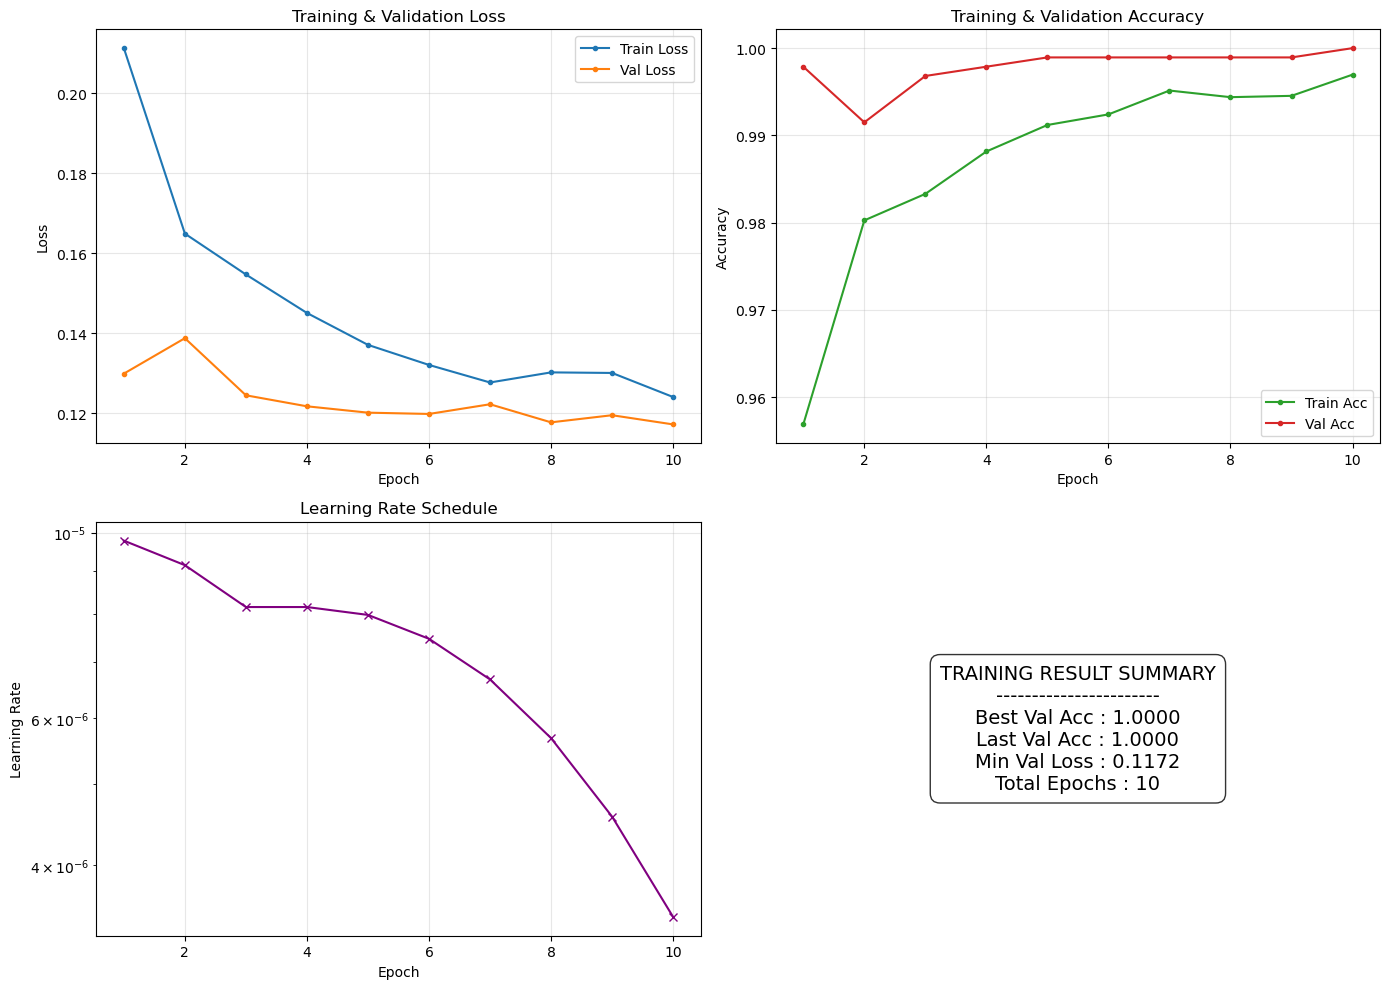

In [11]:
plot_training_history(spatial_trainer.history, spatial_cfg.LOG_DIR)

📊 Đã lưu biểu đồ Validation Metrics tại: ..\..\Outputs\efficientnet\logs\validation_metrics.png


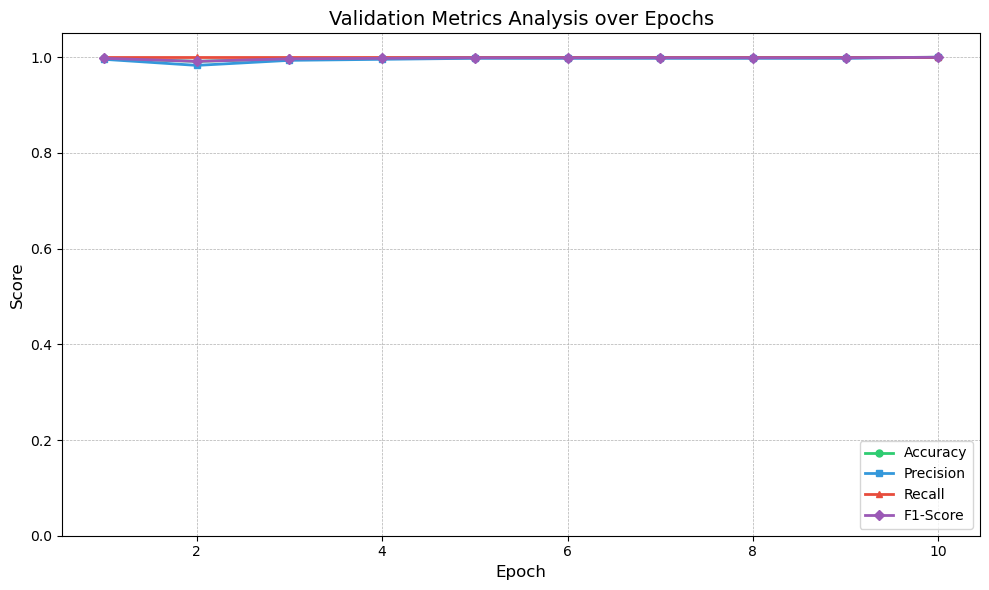

In [12]:
plot_validation_metrics(spatial_trainer.history, spatial_cfg.LOG_DIR)

### Đánh giá mô hình - Evaluate


BẮT ĐẦU ĐÁNH GIÁ TRÊN TẬP TEST


Testing: 100%|██████████| 118/118 [00:36<00:00,  3.23it/s]



📊 KẾT QUẢ ĐÁNH GIÁ:
   Accuracy : 1.0000
   Precision: 1.0000
   Recall   : 1.0000
   F1 Score : 1.0000

📋 Chi tiết theo lớp:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00       956
        Fake       1.00      1.00      1.00       926

    accuracy                           1.00      1882
   macro avg       1.00      1.00      1.00      1882
weighted avg       1.00      1.00      1.00      1882

🔢 Đã lưu Confusion Matrix tại: ..\..\Outputs\efficientnet\logs\evaluation_results\confusion_matrix.png


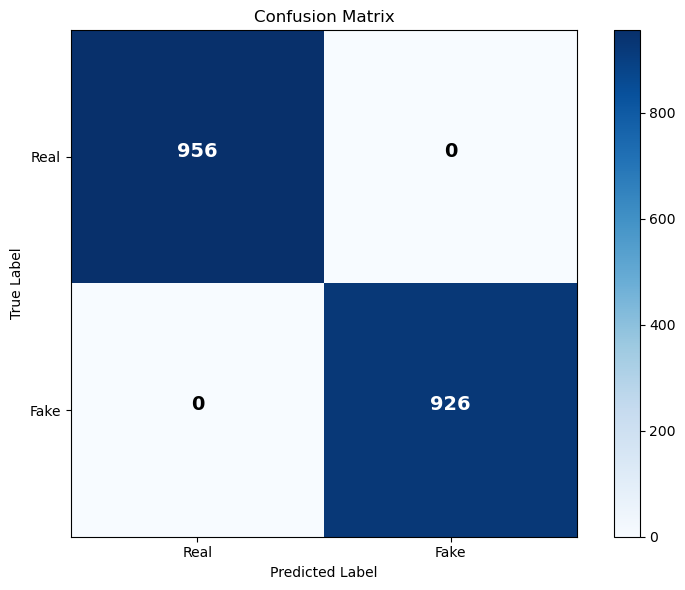

📉 Đã lưu ROC Curve tại: ..\..\Outputs\efficientnet\logs\evaluation_results\roc_curve.png


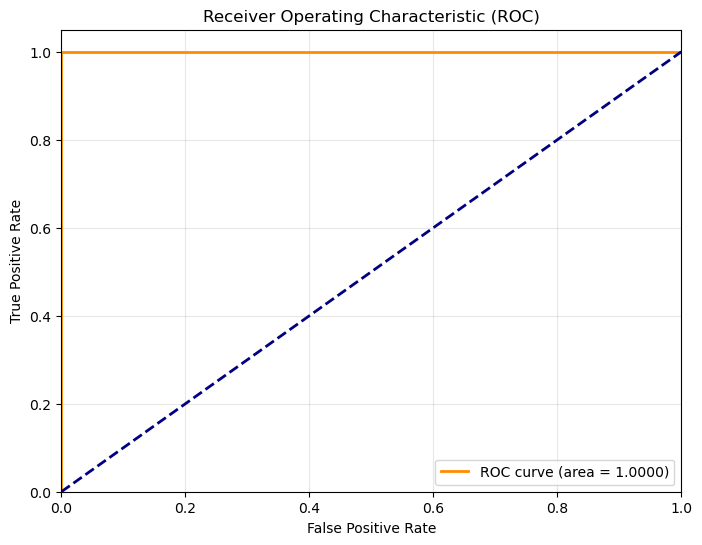

=== ROC AUC Score: 1.0000

Đã lưu toàn bộ kết quả đánh giá tại: ..\..\Outputs\efficientnet\logs\evaluation_results


In [13]:
evaluate_test_set(spatial_model, test_loader, spatial_cfg.DEVICE, spatial_cfg.LOG_DIR)

## Mô hình tần số 

Phân tích miền tần số - FFT

### Khởi tạo mô hình

In [14]:
print(f"Frequency Dimension: {freq_cfg.MODEL_CONFIG['freq_dim']}")

freq_model = build_model(freq_cfg)
freq_trainer = Trainer(
    freq_model, train_loader, val_loader, freq_cfg
)

count_parameters(freq_model)

Frequency Dimension: 256
🛠️ Building Model | Mode: frequency | Device: cuda
📊 Model Summary:
   Total parameters: 1,478,467
   Trainable parameters: 1,478,467


(1478467, 1478467)

### Training

In [15]:
freq_trainer.train()


STARTING TRAINING | Mode: frequency

Epoch 1/10


Validating: 100%|██████████| 59/59 [00:07<00:00,  7.73it/s]



Epoch 1/10 Summary
Train | Loss: 0.5072 | Acc: 0.7780 | F1: 0.7807
Val   | Loss: 0.3682 | Acc: 0.8704
      | Precision: 0.7925 | Recall: 0.9978 | F1: 0.8834
LR    | 0.000098
   New Best Val F1: 0.8834
== Best model saved.

Epoch 2/10


Validating: 100%|██████████| 59/59 [00:07<00:00,  8.13it/s]



Epoch 2/10 Summary
Train | Loss: 0.3087 | Acc: 0.9091 | F1: 0.9092
Val   | Loss: 0.4516 | Acc: 0.8395
      | Precision: 0.7541 | Recall: 1.0000 | F1: 0.8598
LR    | 0.000091
   Epochs without F1 improvement: 1/7

Epoch 3/10


Validating: 100%|██████████| 59/59 [00:08<00:00,  6.94it/s]



Epoch 3/10 Summary
Train | Loss: 0.2552 | Acc: 0.9338 | F1: 0.9337
Val   | Loss: 0.3222 | Acc: 0.9139
      | Precision: 0.8511 | Recall: 1.0000 | F1: 0.9196
LR    | 0.000080
   New Best Val F1: 0.9196
== Best model saved.

Epoch 4/10


Validating: 100%|██████████| 59/59 [00:07<00:00,  8.11it/s]



Epoch 4/10 Summary
Train | Loss: 0.2338 | Acc: 0.9461 | F1: 0.9458
Val   | Loss: 0.3364 | Acc: 0.8927
      | Precision: 0.8209 | Recall: 1.0000 | F1: 0.9017
LR    | 0.000066
   Epochs without F1 improvement: 1/7

Epoch 5/10


Validating: 100%|██████████| 59/59 [00:07<00:00,  8.31it/s]



Epoch 5/10 Summary
Train | Loss: 0.2140 | Acc: 0.9563 | F1: 0.9558
Val   | Loss: 0.2418 | Acc: 0.9405
      | Precision: 0.8921 | Recall: 1.0000 | F1: 0.9430
LR    | 0.000051
   New Best Val F1: 0.9430
== Best model saved.

Epoch 6/10


Validating: 100%|██████████| 59/59 [00:07<00:00,  8.03it/s]



Epoch 6/10 Summary
Train | Loss: 0.2054 | Acc: 0.9601 | F1: 0.9595
Val   | Loss: 0.1720 | Acc: 0.9777
      | Precision: 0.9566 | Recall: 1.0000 | F1: 0.9778
LR    | 0.000035
   New Best Val F1: 0.9778
== Best model saved.

Epoch 7/10


Validating: 100%|██████████| 59/59 [00:07<00:00,  8.18it/s]



Epoch 7/10 Summary
Train | Loss: 0.1926 | Acc: 0.9681 | F1: 0.9679
Val   | Loss: 0.2629 | Acc: 0.9362
      | Precision: 0.8853 | Recall: 1.0000 | F1: 0.9391
LR    | 0.000021
   Epochs without F1 improvement: 1/7

Epoch 8/10


Validating: 100%|██████████| 59/59 [00:07<00:00,  8.33it/s]



Epoch 8/10 Summary
Train | Loss: 0.1924 | Acc: 0.9654 | F1: 0.9652
Val   | Loss: 0.3562 | Acc: 0.9001
      | Precision: 0.8312 | Recall: 1.0000 | F1: 0.9078
LR    | 0.000010
   Epochs without F1 improvement: 2/7

Epoch 9/10


Validating: 100%|██████████| 59/59 [00:07<00:00,  8.35it/s]



Epoch 9/10 Summary
Train | Loss: 0.1924 | Acc: 0.9649 | F1: 0.9647
Val   | Loss: 0.1974 | Acc: 0.9607
      | Precision: 0.9260 | Recall: 1.0000 | F1: 0.9616
LR    | 0.000003
   Epochs without F1 improvement: 3/7

Epoch 10/10


Validating: 100%|██████████| 59/59 [00:07<00:00,  8.39it/s]



Epoch 10/10 Summary
Train | Loss: 0.1807 | Acc: 0.9695 | F1: 0.9693
Val   | Loss: 0.2844 | Acc: 0.9256
      | Precision: 0.8687 | Recall: 1.0000 | F1: 0.9297
LR    | 0.000001
   Epochs without F1 improvement: 4/7

Training Completed. Best F1: 0.9778
History saved to: ..\..\Outputs\frequency\logs\training_history.json


### Trực quan quá trình huấn luyện  

📈 Đã lưu biểu đồ training tại: ..\..\Outputs\frequency\logs\training_history.png


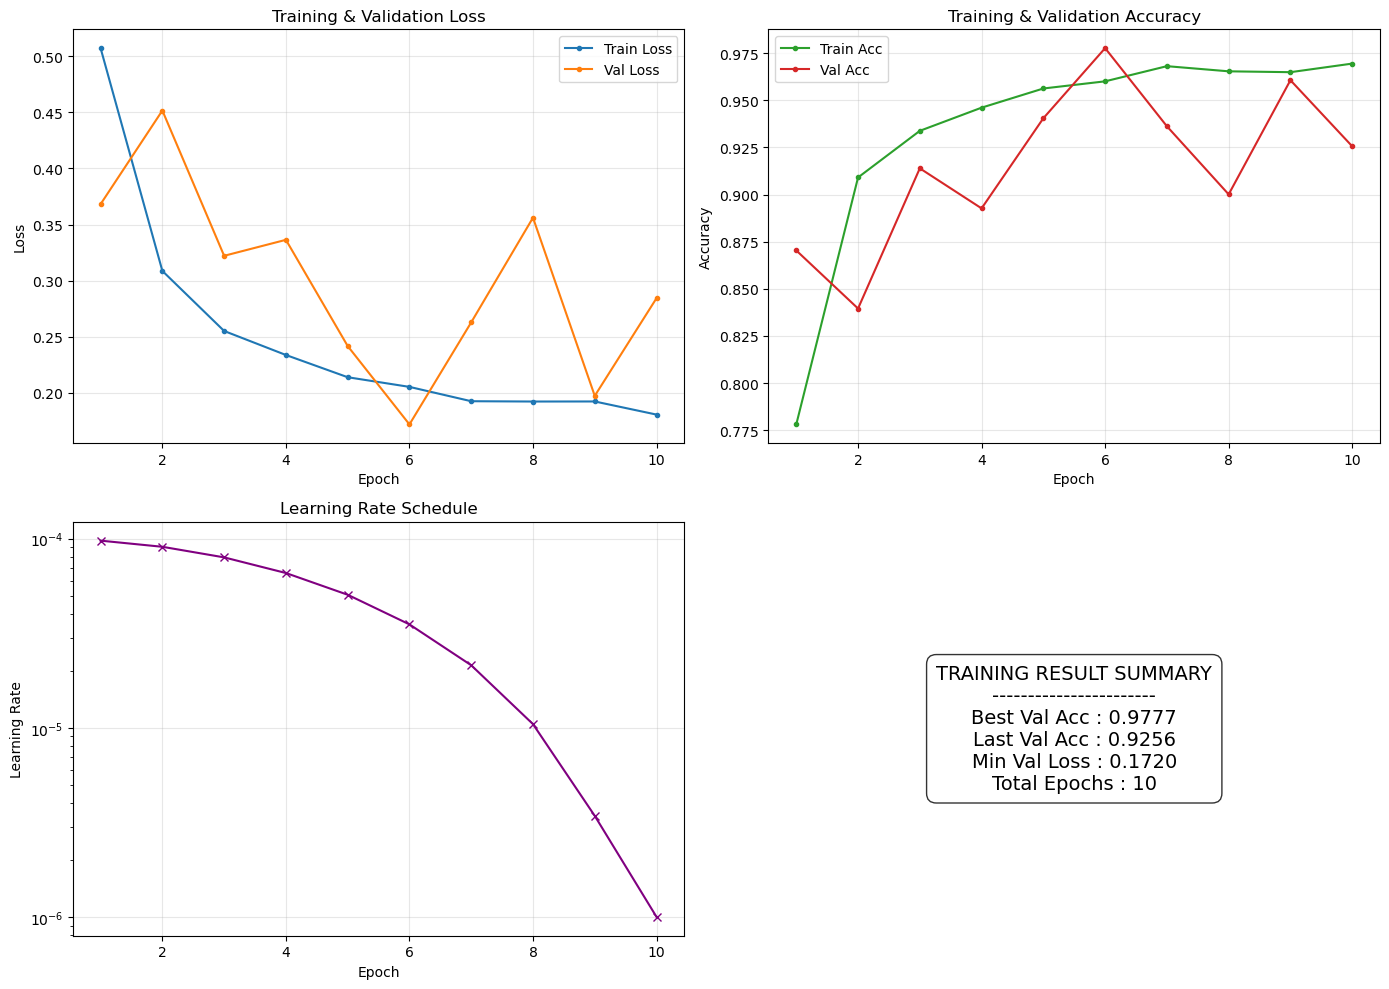

In [16]:
plot_training_history(freq_trainer.history, freq_cfg.LOG_DIR)

### Đánh giá mô hình - Evaluate


BẮT ĐẦU ĐÁNH GIÁ TRÊN TẬP TEST


Testing: 100%|██████████| 118/118 [00:20<00:00,  5.73it/s]



📊 KẾT QUẢ ĐÁNH GIÁ:
   Accuracy : 0.9362
   Precision: 0.8853
   Recall   : 1.0000
   F1 Score : 0.9391

📋 Chi tiết theo lớp:
              precision    recall  f1-score   support

        Real       1.00      0.87      0.93       956
        Fake       0.89      1.00      0.94       926

    accuracy                           0.94      1882
   macro avg       0.94      0.94      0.94      1882
weighted avg       0.94      0.94      0.94      1882

🔢 Đã lưu Confusion Matrix tại: ..\..\Outputs\frequency\logs\evaluation_results\confusion_matrix.png


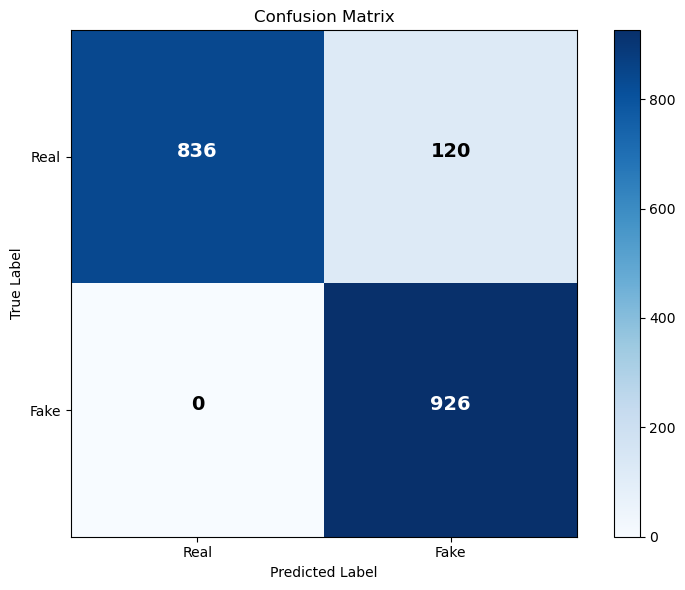

📉 Đã lưu ROC Curve tại: ..\..\Outputs\frequency\logs\evaluation_results\roc_curve.png


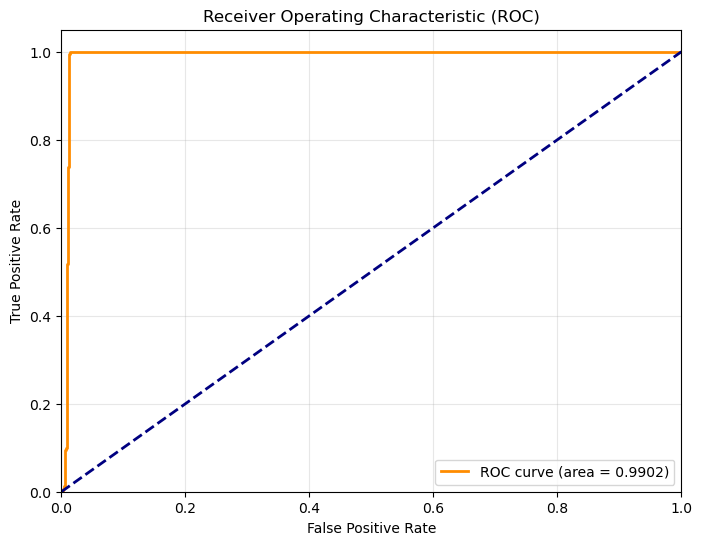

=== ROC AUC Score: 0.9902

Đã lưu toàn bộ kết quả đánh giá tại: ..\..\Outputs\frequency\logs\evaluation_results


In [17]:
evaluate_test_set(freq_model, test_loader, freq_cfg.DEVICE, freq_cfg.LOG_DIR)

## Mô hình kết hợp

### Khởi tạo mô hình - Asymmetric

In [20]:
print(f"Model name: {hybrid_asym_cfg.MODEL_NAME}")
print(f"Frequency dimension: {hybrid_asym_cfg.MODEL_CONFIG['freq_dim']}")
print(f"Spatial dimension: {hybrid_asym_cfg.MODEL_CONFIG['spatial_dim']}")
print(hybrid_asym_cfg.MODEL_CONFIG['use_attention_fusion'])

hybrid_model = build_model(hybrid_asym_cfg)

hybrid_trainer = Trainer(
    hybrid_model, train_loader, val_loader, hybrid_asym_cfg
)

Model name: efficientnet_fft_asym
Frequency dimension: 256
Spatial dimension: 512
True
🛠️ Building Model | Mode: hybrid | Device: cuda


### Training

In [21]:
hybrid_trainer.train()


STARTING TRAINING | Mode: hybrid

Epoch 1/10
[INFO] Freezing backbone at epoch 0
== Spatial Branch is now Frozen.


Validating: 100%|██████████| 59/59 [00:09<00:00,  6.25it/s]



Epoch 1/10 Summary
Train | Loss: 0.2408 | Acc: 0.9408 | F1: 0.9396
Val   | Loss: 0.1426 | Acc: 0.9979
      | Precision: 0.9957 | Recall: 1.0000 | F1: 0.9978
LR    | 0.000010
   New Best Val F1: 0.9978
== Best model saved.

Epoch 2/10


Validating: 100%|██████████| 59/59 [00:08<00:00,  6.59it/s]



Epoch 2/10 Summary
Train | Loss: 0.1784 | Acc: 0.9750 | F1: 0.9745
Val   | Loss: 0.1415 | Acc: 0.9883
      | Precision: 0.9768 | Recall: 1.0000 | F1: 0.9883
LR    | 0.000009
   Epochs without F1 improvement: 1/7

Epoch 3/10


Validating: 100%|██████████| 59/59 [00:09<00:00,  6.38it/s]



Epoch 3/10 Summary
Train | Loss: 0.1601 | Acc: 0.9828 | F1: 0.9826
Val   | Loss: 0.1422 | Acc: 0.9894
      | Precision: 0.9789 | Recall: 1.0000 | F1: 0.9893
LR    | 0.000008
   Epochs without F1 improvement: 2/7

Epoch 4/10
[INFO] Unfreezing backbone at epoch 3
== Spatial Branch is now Unfrozen.


Validating: 100%|██████████| 59/59 [00:09<00:00,  6.30it/s]



Epoch 4/10 Summary
Train | Loss: 0.1545 | Acc: 0.9847 | F1: 0.9844
Val   | Loss: 0.1211 | Acc: 0.9979
      | Precision: 0.9957 | Recall: 1.0000 | F1: 0.9978
LR    | 0.000008
   Epochs without F1 improvement: 3/7

Epoch 5/10


Validating: 100%|██████████| 59/59 [00:10<00:00,  5.80it/s]



Epoch 5/10 Summary
Train | Loss: 0.1411 | Acc: 0.9900 | F1: 0.9898
Val   | Loss: 0.1177 | Acc: 1.0000
      | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
LR    | 0.000008
   New Best Val F1: 1.0000
== Best model saved.

Epoch 6/10


Validating: 100%|██████████| 59/59 [00:11<00:00,  5.20it/s]



Epoch 6/10 Summary
Train | Loss: 0.1336 | Acc: 0.9935 | F1: 0.9934
Val   | Loss: 0.1205 | Acc: 0.9989
      | Precision: 0.9978 | Recall: 1.0000 | F1: 0.9989
LR    | 0.000007
   Epochs without F1 improvement: 1/7

Epoch 7/10


Validating: 100%|██████████| 59/59 [00:13<00:00,  4.23it/s]



Epoch 7/10 Summary
Train | Loss: 0.1275 | Acc: 0.9957 | F1: 0.9957
Val   | Loss: 0.1203 | Acc: 0.9989
      | Precision: 0.9978 | Recall: 1.0000 | F1: 0.9989
LR    | 0.000007
   Epochs without F1 improvement: 2/7

Epoch 8/10


Validating: 100%|██████████| 59/59 [00:09<00:00,  5.93it/s]



Epoch 8/10 Summary
Train | Loss: 0.1286 | Acc: 0.9956 | F1: 0.9955
Val   | Loss: 0.1193 | Acc: 0.9989
      | Precision: 0.9978 | Recall: 1.0000 | F1: 0.9989
LR    | 0.000006
   Epochs without F1 improvement: 3/7

Epoch 9/10


Validating: 100%|██████████| 59/59 [00:09<00:00,  6.38it/s]



Epoch 9/10 Summary
Train | Loss: 0.1262 | Acc: 0.9967 | F1: 0.9966
Val   | Loss: 0.1188 | Acc: 0.9989
      | Precision: 0.9978 | Recall: 1.0000 | F1: 0.9989
LR    | 0.000005
   Epochs without F1 improvement: 4/7

Epoch 10/10


Validating: 100%|██████████| 59/59 [00:09<00:00,  6.55it/s]



Epoch 10/10 Summary
Train | Loss: 0.1258 | Acc: 0.9964 | F1: 0.9963
Val   | Loss: 0.1193 | Acc: 0.9989
      | Precision: 0.9978 | Recall: 1.0000 | F1: 0.9989
LR    | 0.000003
   Epochs without F1 improvement: 5/7

Training Completed. Best F1: 1.0000
History saved to: ..\..\Outputs\efficientnet_fft_asym\logs\training_history.json


### Trực quan kết quả huấn luyện

📈 Đã lưu biểu đồ training tại: ..\..\Outputs\efficientnet_fft_asym\logs\training_history.png


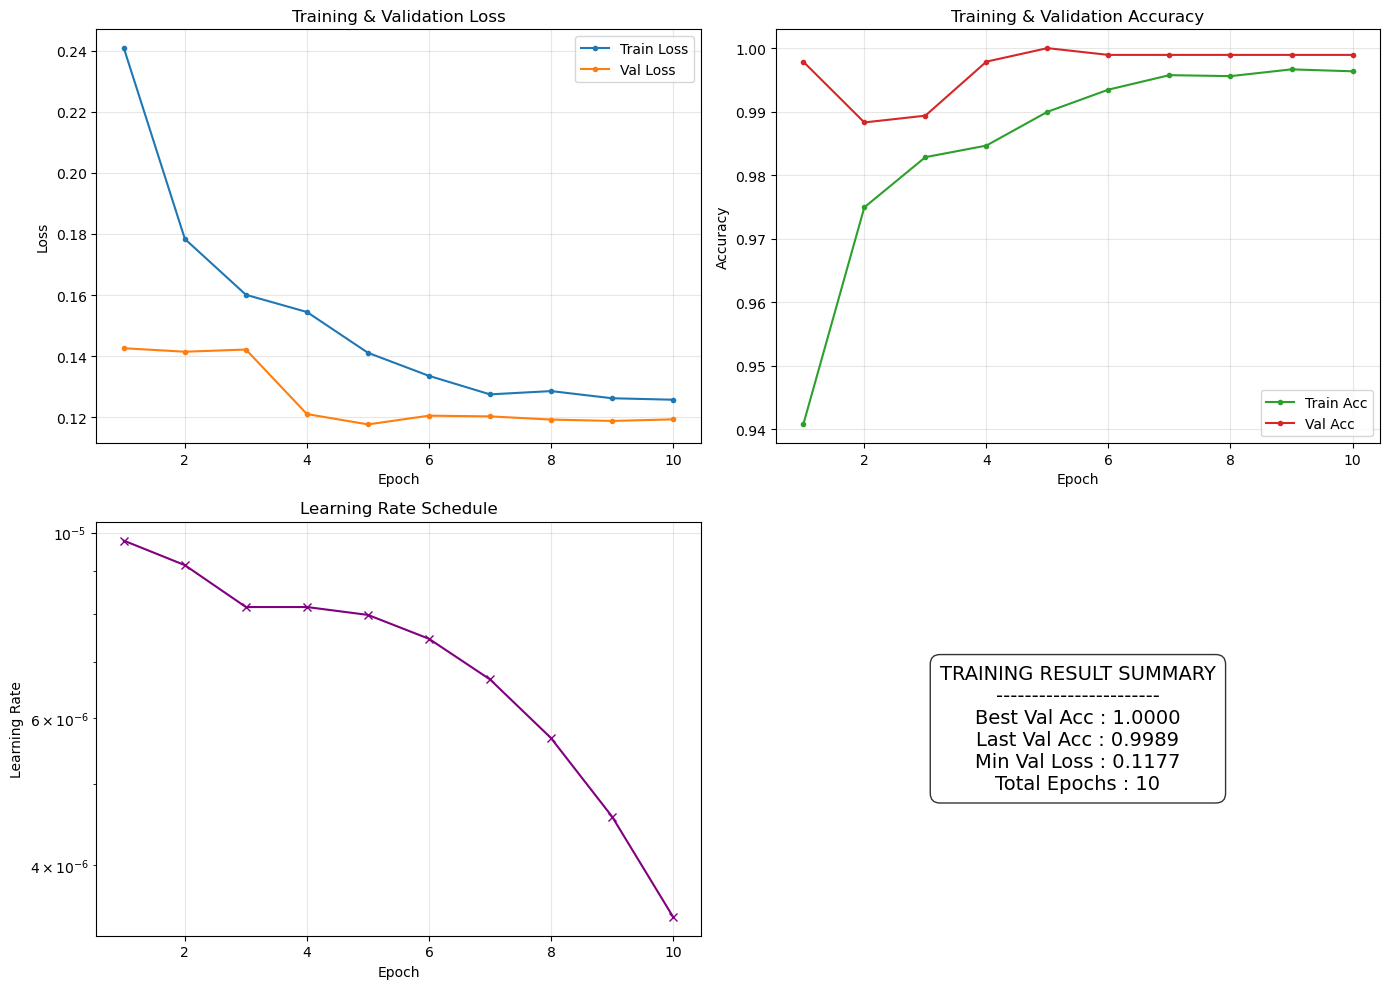

In [23]:
plot_training_history(hybrid_trainer.history, hybrid_asym_cfg.LOG_DIR)

### Đánh giá mô hình - Evaluate


BẮT ĐẦU ĐÁNH GIÁ TRÊN TẬP TEST


Testing:   0%|          | 0/118 [00:00<?, ?it/s]

Testing: 100%|██████████| 118/118 [00:24<00:00,  4.86it/s]



📊 KẾT QUẢ ĐÁNH GIÁ:
   Accuracy : 0.9995
   Precision: 0.9989
   Recall   : 1.0000
   F1 Score : 0.9995

📋 Chi tiết theo lớp:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00       956
        Fake       1.00      1.00      1.00       926

    accuracy                           1.00      1882
   macro avg       1.00      1.00      1.00      1882
weighted avg       1.00      1.00      1.00      1882

🔢 Đã lưu Confusion Matrix tại: ..\..\Outputs\efficientnet_fft_asym\logs\evaluation_results\confusion_matrix.png


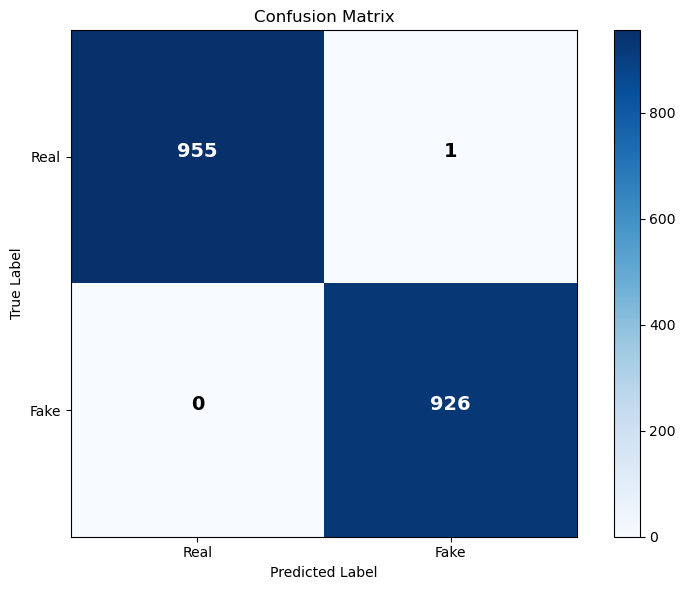

📉 Đã lưu ROC Curve tại: ..\..\Outputs\efficientnet_fft_asym\logs\evaluation_results\roc_curve.png


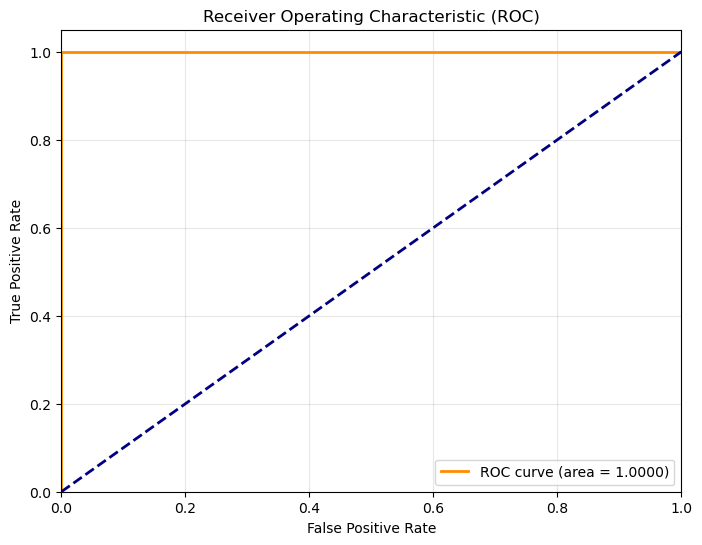

=== ROC AUC Score: 1.0000

Đã lưu toàn bộ kết quả đánh giá tại: ..\..\Outputs\efficientnet_fft_asym\logs\evaluation_results


In [25]:
evaluate_test_set(hybrid_model, test_loader, hybrid_asym_cfg.DEVICE, hybrid_asym_cfg.LOG_DIR)